Maybe easier to follow https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=chatbot%20tutorial

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import numpy as np
from io import open
import itertools
import math
import matplotlib.pyplot as plt
%matplotlib inline


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [2]:
print(device)

cpu


In [3]:
corpus_name = "cornell movie-dialogs corpus"
corpus = os.path.join("../dat/", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

#printLines(os.path.join(corpus, "movie_lines.txt"))


In [4]:
# Splits each line of the file into a dictionary of fields
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines


# Groups fields of lines from `loadLines` into conversations based on *movie_conversations.txt*
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs


# Extracts cleaned dialogue sentences from conversations
def extractConversation(conversations):
    clean_conversation = []
    for conversation in conversations:
        convo = []
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"])):  # We ignore the last line (no answer for it)
            Line = conversation["lines"][i]["text"].strip()
            convo.append(Line)
        if len(convo) > 2: #there has to be a reply? 
            clean_conversation.append(convo)

    return clean_conversation

In [5]:
# Define path to new file

datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict, conversations list, and field ids
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# Load lines and process conversations
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

convos = extractConversation(conversations)
# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)


    


Processing corpus...

Loading conversations...

Writing newly formatted file...


In [6]:
# Little bit of eda.. 
convo_lengths = []
utterance_lengths = []
for convo in convos:
    conversation_length = len(convo)
    if conversation_length > 2:
 #       print(convo)
        convo_lengths.append(conversation_length)
        for sentence in convo:
            utterance_lengths.append(len(sentence.split(' ')))

Text(0, 0.5, 'Frequency')

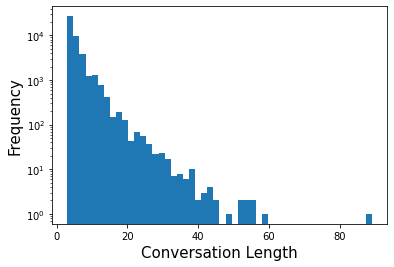

In [7]:
plt.hist(convo_lengths,bins=50)
plt.yscale('log')
plt.xlabel('Conversation Length',fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)

Text(0, 0.5, 'Frequency')

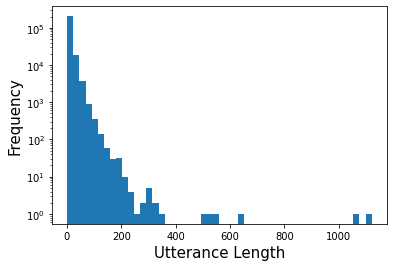

In [8]:
plt.hist(utterance_lengths,bins=50)
plt.yscale('log')
plt.xlabel('Utterance Length',fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)

In [9]:
class DialogEnvironment(object):
    """
    
    Gym environment for dialog.
    
    """
    def __init__(self, mode='train'):
        

        self.conversations = extractConversation(conversations)
        
    
        if mode == 'train':
            self.conversations = self.conversations[:-10]
        elif mode == 'test':
            self.conversations = self.conversations[-10]
            
        
        self.conversations_visited = []
        
    def clear(self):
        self.conversations_visited = [] #
    def current_state(self):
        return i,j # i for current conversation index, j for current word (these should be odd? )
    
    def reset(self):
        # pick a random i in length of convos. If in convos visited, skip
        
        self.i = random.randint(a=0,b=len(self.conversations))
        
        
        self.conversations_visited.append(self.i)
        self.conversation = self.conversations[self.i]
        self.j = 0
        state = self.conversation[self.j]
        return state
    def step(self,action):
        done = False
        self.j +=2 
        new_state = self.conversation[self.j]
        
        if new_state in self.conversation[-2:]: # if this last obs was either the last or second last thing, end here. 
            done = True
        
        return new_state, done


In [10]:
env = DialogEnvironment()

In [11]:
i = 0
while i < 5:
    state  = env.reset()
    print("~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~")
    print('first state : ', state)
    while True:
     #   action = "Fuck that, I'm not even supposed to be here "
        action = env.conversation[env.j - 1] #it's already a part of the env,
        print("agent action : ", action)
        new_state, done = env.step(action)
#        print("agent action : ", expert_action, env.j)
        print("next state : ", new_state)
        if done:
            break

    i += 1

~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~
first state :  You think I love Jessica and want her back. It is like you to think that -- clean, decent thinking.
agent action :  I hated her.
next state :  I hated her.
~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~
first state :  My, my. You have exceeded my expectations.
agent action :  No, sir. Plainly put, I never expect to sleep again.
next state :  How is the patient faring?
agent action :  And my own.
next state :  And you? It must've been an ordeal.
agent action :  Poorly.
next state :  Will you sleep soundly tonight?
~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~
first state :  Knock knock.
agent action :  Monkey, this is too exciting! I can't believe our dream is coming true.
next state :  Guess what"s under these coconuts.
agent action :  Who's there?
next state :  It's a surprise.
agent action :  What?
next state :  You got the Extender?
agent action :  Well I've got a little surprise for you.
next state :  Monkey, this is too exci

# Dummy Embeddings

## Using https://github.com/YuriyGuts/thrones2vec/blob/master/Thrones2Vec.ipynb

In [1]:
from flair.embeddings import WordEmbeddings
from flair.data import Sentence

# init embedding
glove_embedding = WordEmbeddings('glove')

/scratch/nsk367/anaconda3/envs/irl/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


2020-12-01 19:47:15,666 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /state/partition1/job-14005502/tmpg2k66b48


100%|██████████| 160000128/160000128 [00:11<00:00, 13518461.63B/s]

2020-12-01 19:47:27,912 copying /state/partition1/job-14005502/tmpg2k66b48 to cache at /home/nsk367/.flair/embeddings/glove.gensim.vectors.npy


2020-12-01 19:47:28,311 removing temp file /state/partition1/job-14005502/tmpg2k66b48
2020-12-01 19:47:28,681 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /state/partition1/job-14005502/tmpxckjyv06


100%|██████████| 21494764/21494764 [00:01<00:00, 14461513.12B/s]

2020-12-01 19:47:30,528 copying /state/partition1/job-14005502/tmpxckjyv06 to cache at /home/nsk367/.flair/embeddings/glove.gensim


2020-12-01 19:47:30,592 removing temp file /state/partition1/job-14005502/tmpxckjyv06


In [3]:
# create sentence.
sentence = Sentence('grass grass is green .')

# embed a sentence using glove.
glove_embedding.embed(sentence)

# now check out the embedded tokens.
for token in sentence:
    print(token)
    print(token.embedding)

Token: 1 grass
tensor([-0.8135,  0.9404, -0.2405, -0.1350,  0.0557,  0.3363,  0.0802, -0.1015,
        -0.5478, -0.3537,  0.0734,  0.2587,  0.1987, -0.1433,  0.2507,  0.4281,
         0.1950,  0.5346,  0.7424,  0.0578, -0.3178,  0.9436,  0.8145, -0.0824,
         0.6166,  0.7284, -0.3262, -1.3641,  0.1232,  0.5373, -0.5123,  0.0246,
         1.0822, -0.2296,  0.6039,  0.5541, -0.9610,  0.4803,  0.0022,  0.5591,
        -0.1637, -0.8468,  0.0741, -0.6216,  0.0260, -0.5162, -0.0525, -0.1418,
        -0.0161, -0.4972, -0.5534, -0.4037,  0.5096,  1.0276, -0.0840, -1.1179,
         0.3226,  0.4928,  0.9488,  0.2040,  0.5388,  0.8397, -0.0689,  0.3136,
         1.0450, -0.2267, -0.0896, -0.6427,  0.6443, -1.1001, -0.0096,  0.2668,
        -0.3230, -0.6065,  0.0479, -0.1664,  0.8571,  0.2335,  0.2539,  1.2546,
         0.5472, -0.1980, -0.7186,  0.2076, -0.2587, -0.3650,  0.0834,  0.6932,
         0.1574,  1.0931,  0.0913, -1.3773, -0.2717,  0.7071,  0.1872, -0.3307,
        -0.2836,  0.1030,